In [30]:
# Import all the necessary libraries

import os
import numpy as np
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm

In [31]:
# Set the device to cuda if available
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Clear the cache and empty the GPU memory if cuda is available
if def_device == 'cuda':
    gc.collect()
    torch.cuda.empty_cache()

In [32]:
# Function to load tensors into GPU
# Very useful when we have to load a batch of tensors into GPU and makes life easier

def to_device(x,device = def_device):
  if isinstance(x, torch.Tensor): return x.to(device) # if x is a tensor, move it to the device
  return type(x)(to_device(o, device) for o in x) # if x is a list or tuple, recursively move all the elements to the device

In [33]:
# Define the data directory

data_dir = "archive/PokemonData"

In [34]:
# Get the list of all the pokemon names

pokemon_names = os.listdir(data_dir)
len(pokemon_names)

150

In [35]:
# Make a list of all the image paths and their corresponding classes
# Create a dictionary of pokemon names and their corresponding index for easy lookup

image_paths = []
image_classes = []
int_to_class = {}
class_to_int = {}

In [36]:
# Loop through the directory and get the image paths and classes

for i in range(len(pokemon_names)):
    image_names = os.listdir(data_dir+'/' + pokemon_names[i])
    int_to_class[i] = pokemon_names[i]
    class_to_int[pokemon_names[i]] = i
    for j in range(len(image_names)):
        if image_names[j][-3:] == 'jpg':
            image_paths.append(data_dir +'/'+ pokemon_names[i] + "/" + image_names[j])
            image_classes.append(i)

In [37]:
# Shuffle the image paths and classes
# This is done so that we can split the dataset into train and validation sets and also to make sure that the model doesn't overfit on a particular class
# There are probably better ways to do this but this is one way that does the job

rng_state = np.random.get_state()
np.random.shuffle(image_paths)
np.random.set_state(rng_state)
np.random.shuffle(image_classes)

In [38]:
# Define the split ratio for train and validation sets

train_spilt = 0.8

In [39]:
# Split the dataset into train and validation sets

train_paths = image_paths[:int(len(image_paths)*train_spilt)]
train_classes = image_classes[:int(len(image_paths)*train_spilt)]

test_paths = image_paths[int(len(image_paths)*train_spilt):]
test_classes = image_classes[int(len(image_paths)*train_spilt):]

In [40]:
# Define the transforms for train and validation sets
# The transforms are defined in such a way that the model can learn the features of the pokemon and not the background
# The training set has random transformations applied to it so that the model can learn the features of the pokemon from different angles and positions
# Also data augmentation is done to increase the size of the dataset and to make the model more robust and to prevent overfitting

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])  

# The validation set has no random transformations applied to it 
# We resize the image to 224x224 and convert it to a tensor which is the input format for the resnet50 model
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])  

# This is a normalization transform that is applied to the input images
# The values are taken from the resnet50 model documentation
# It helps the model to learn faster
normalization_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

In [41]:
# Create our own dataset class
# This is done so that we can load the images in batches and apply the transforms to them
# Inherit the torch.utils.data.Dataset class and override the __len__ and __getitem__ methods
# __len__ method returns the length of the dataset
# __getitem__ method returns the image and its corresponding class


class PokemonDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, image_classes, transform=None):
        self.image_paths = image_paths
        self.image_classes = image_classes
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        while True:
          # Try except block is used because some of the images in the dataset are corrupted and cannot be opened
          # So we try to open the image and if it fails we randomly select another image
          try:                         
            image = Image.open(self.image_paths[idx])
            break
          except:
            idx = random.randint(0,len(self.image_paths)-1)
        # Apply the transforms to the image
        image = self.transform(image)

        # Some of the images in the dataset have 1 and 4 channels instead of 3
        # So we repeat the channels if the image has 1 channel and remove the alpha channel if the image has 4 channels
        if image.shape[0] == 1:
            image = image.repeat(3,1,1)
        elif image.shape[0] == 4:
            image = image[:3,:,:]

        # Apply the normalization transform to the image and return the image and its corresponding class
        image = normalization_transform(image)
        return image, self.image_classes[idx]

In [42]:
# Create the train and validation datasets using the PokemonDataset class and the transforms defined above

train_dataset = PokemonDataset(train_paths, train_classes, transform=train_transform)
test_dataset = PokemonDataset(test_paths, test_classes, transform=test_transform)

In [43]:
# Create the train and validation dataloaders 
# Set the batch size and shuffle the train dataloader

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


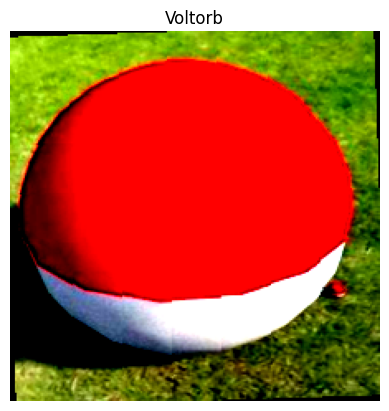

In [44]:
# Visualize an image from the train dataloader

batch = next(iter(train_loader))
img,label = batch
img = img[0]
img = img.permute(1,2,0)
plt.imshow(img)
plt.title(int_to_class[int(label[0])])
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


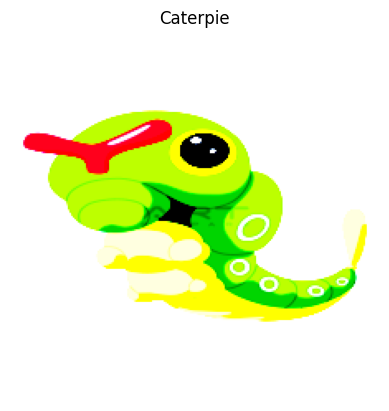

In [45]:
# Visualize an image from the validation dataloader

batch = next(iter(test_loader))
img,label = batch
img = img[0]
img = img.permute(1,2,0)
plt.imshow(img)
plt.title(int_to_class[int(label[0])])
plt.axis('off')
plt.show()

In [46]:
# Define the ResBlock class
# This is used to create the resnet50 model
# This the basic building block of the resnet50 model which is repeated multiple times to create the model
# The code for this class is taken from the pytorch documentation

class ResBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [47]:
# Function to create a layer of the resnet50 model
# A layer consists of multiple ResBlocks with same number of input and output channels
# The code for this function is taken from the pytorch documentation

def _make_layer(block,inplanes,planes, blocks, stride=1):
    downsample = None
    if stride != 1 or inplanes != planes:
        downsample = nn.Sequential(
            nn.Conv2d(inplanes, planes, 1, stride, bias=False),
            nn.BatchNorm2d(planes),
        )
    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))
    return nn.Sequential(*layers)

In [48]:
# Define the ResNet class
# Put together all the layers to create the resnet50 model
# Define the forward method which is used to pass the input through the model
# The code for this class is taken from the pytorch documentation
# Set the number of classes to 150 since we have 150 pokemon classes

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=150):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = _make_layer(block,self.inplanes, 64, layers[0])
        self.layer2 = _make_layer(block,64, 128, layers[1], stride=2)
        self.layer3 = _make_layer(block,128, 256, layers[2], stride=2)
        self.layer4 = _make_layer(block,256, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)

    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # convert 1 X 1 to vector
        x = self.fc(x)

        return x

In [49]:
model = ResNet(ResBlock, [3, 4, 6, 3])  # ResNet50 model. The values 3,4,6,3 are taken from the paper

# Load the resnet50 model if it is already trained
# model = torch.load('pokemon_classifier.pth',map_location=torch.device('cpu') )

# # Send the model to the device (GPU or CPU)
# model = model.to(def_device)

In [50]:
# Function to evalute the model on the test dataset

def evaluate(model, test_dl, crit):
    total = 0
    correct = 0
    tot_loss = 0
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():  # No need to calculate gradients when evaluating the model
        for x, y in test_dl:
            x = to_device(x)
            y = to_device(y)
            o = model(x)
            l = crit(o,y)
            tot_loss += l.item()
            correct += torch.sum(torch.argmax(o,axis=1) == y).item()
            total += len(y)
        test_loss = tot_loss / len(test_dl)
        test_acc = 100 * correct / total
        return test_loss, test_acc

In [51]:
# Function to train the model for one epoch on the train datset

def train_one_epoch(model, train_dl, crit, optim):
    total = 0
    correct = 0
    tot_loss = 0
    model.train() # Set the model to training mode
    for x, y in tqdm(train_dl,total=len(train_dl)):
        optim.zero_grad()
        x = to_device(x)
        y = to_device(y)
        o = model(x)
        l = crit(o,y)
        l.backward()
        optim.step()
        tot_loss += l.item()
        correct += torch.sum(torch.argmax(o,axis=1) == y).item()
        total += len(y)
    train_loss = tot_loss / len(train_dl)
    train_acc = 100 * correct / total
    return train_loss, train_acc

In [52]:
# Train for the specified number of epochs

def train(model, train_dl, test_dl, crit, optim, lr_sched=None, epochs=10):
    for epoch in tqdm(range(epochs),total=epochs):
        train_loss, train_acc = train_one_epoch(model, train_dl, crit, optim)
        test_loss, test_acc = evaluate(model, test_dl, crit)
        if lr_sched is not None:
            lr_sched.step() # Update the learning rate if a scheduler is passed
        print(f"epoch: {epoch}, train loss: {train_loss}, train accuracy: {train_acc:.2f}%, test loss: {test_loss}, test accuracy: {test_acc:.2f}%")

In [53]:
# Define the optimizer, learning rate scheduler and the loss function
# I have used the SGD optimizer with momentum and the CosineAnnealingLR learning rate scheduler
# The loss function is the cross entropy loss function
# You can also use Adam with any learning rate scheduler of your choice

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()

In [54]:
# Train the model for 15 epochs
# Also I tried to use tqdm for the progress bar but it didn't work as expected so 
# progress bars might be little buggy

# train(model, train_loader, test_loader, criterion, optimizer, epochs=15, lr_sched=lr_sched)

In [55]:
# Function to predict the class of an image given its path and true class

def predict(image_path, label):
    img = Image.open(image_path)
    plt.imshow(img)

    # Apply the transforms to the image and convert it to a tensor (Necessary for the model as it was trained using such a transformation)
    img = test_transform(img) 
    img = normalization_transform(img) 
    img = img.unsqueeze(0) # Add a batch dimension to the image 

    # Pass the image through the model and get the prediction and the corresponding class
    # Plot the image and the predicted class along with the true class

    model.eval() # Set the model to evaluation mode
    pred = model(img)
    predicted_class = np.argmax(pred.detach().numpy())
    class_ = int_to_class[int(predicted_class)]
    plt.title(f"True: {int_to_class[int(label)]}    Predicted: {class_}")

AttributeError: 'ResNet' object has no attribute 'conv1'

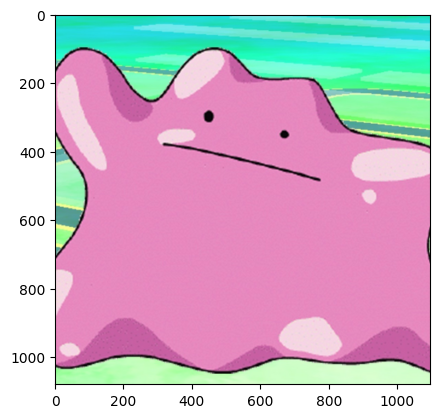

In [56]:
# Visualize the predictions of the model on the dataset
# Select a random image from the dataset

num = random.randint(0,len(image_paths)-1) 
img = image_paths[num]
label = image_classes[num]


predict(img, label)

In [ ]:
# For some fun 
# We can download new images from the web and test our model on them
# I have used the bing_image_downloader library to download the images
# You can install it using `pip install bing_image_downloader`

import shutil
def predict_web():
    input_query = input()
    from bing_image_downloader import downloader
    pokemons = [names.lower() for names in pokemon_names]
    if input_query.lower() in pokemons:
        downloader.download(input_query,limit=3,output_dir='dataset',adult_filter_off=True,force_replace=False,verbose=False)
        for image in os.listdir(f'dataset/{input_query}'):
            try:
                predict(f'dataset/{input_query}/'+image, class_to_int[input_query.title()])
                return
            except:
                continue
        print("Something went wrong, please try again")
    else:
        print(f'Please enter a valid generation 1 pokemon name')
    shutil.rmtree(f'dataset/{input_query}', ignore_errors=True)

In [ ]:
# Let's try it out
# Downloading may take some time (1-2 minutes)

predict_web()

Please enter a valid generation 1 pokemon name
